In [53]:
from numpy.random import seed
seed(42)
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [54]:
from utils import load_data, vis_data, general_preprocessing, get_dataset, get_results, draw_saliency, draw_CAM

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import os
import json

In [55]:
#Se crea una lista para cada clase de imágenes y se guardan en cada una los paths correspondientes
lung_aca, lung_n, lung_scc = load_data()

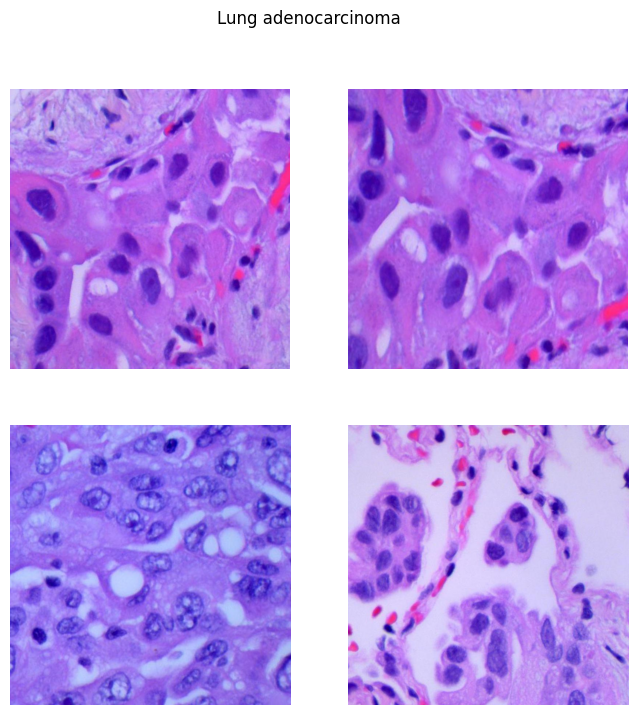

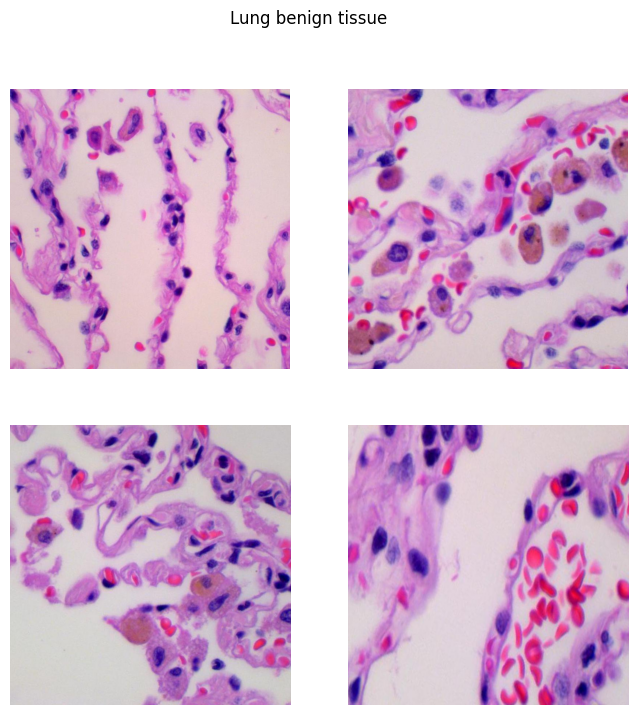

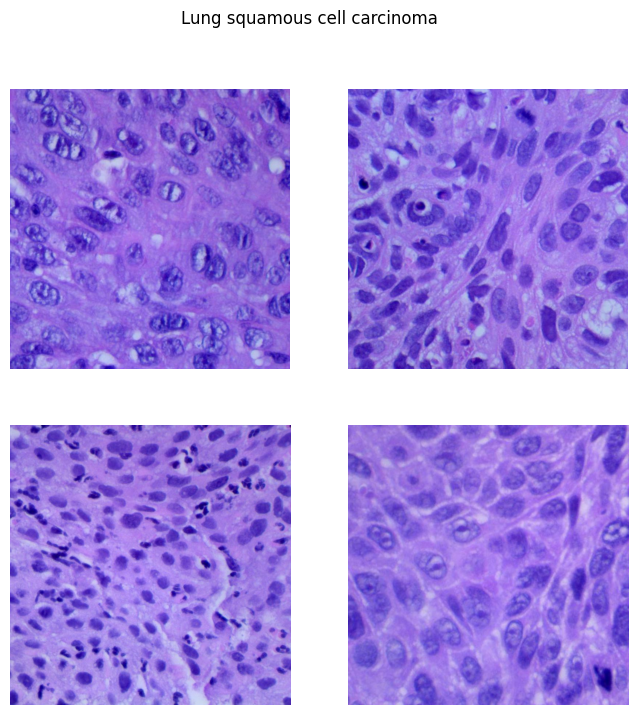

In [56]:
#Se previsualizan las imágenes.
vis_data(lung_aca, lung_n, lung_scc)

In [57]:
# Se crean las variables necesarias para la normalización de las imágenes:

alfa = 0.75 #alfa defines the width of the input intensity range
beta = 0 #beta defines the intensity around which the range is centered
# Información sobre parámetros alfa y beta en: https://itk.org/ItkSoftwareGuide.pdf

def preprocessing_simpleConv(image_path, label):

    image, label = general_preprocessing(image_path, label)
    
    hsv_image = tf.image.rgb_to_hsv(image)
    n_image = (255-0)*(1/(1+tf.math.exp((-1)*((hsv_image[:,:,2]- beta)/ alfa))))
    #La linea superior es una normalización NO lineal    
    
    norm_image = tf.stack([hsv_image[:,:,0], hsv_image[:,:,1], n_image], axis = -1)
    norm_image = tf.image.hsv_to_rgb(norm_image)
     
    norm_image = tf.cast(norm_image, tf.float32) / 255.0  
    
    return norm_image, label

In [58]:
#Se dividen los datos en los conjuntos de training, validation y testing.
train_dataset, val_dataset, test_dataset = get_dataset(preprocessing_simpleConv, lung_aca, lung_n, lung_scc)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [59]:
#Se crea el modelo.

SimpleConv = tf.keras.models.Sequential([

  tf.keras.layers.InputLayer(input_shape = (350, 350, 3)),

  tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GaussianNoise(0.01),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.GaussianNoise(0.01),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'SAME'),
  tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(), #La capa Flatten es para tener los datos en una sola dimensión, las capas siguientes ya serán fully-connected.
  tf.keras.layers.Dense(4096),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2048),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(16),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(8),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(3),
  tf.keras.layers.Softmax()

])

#Las capas Dropout aumentan la generalitzación porque se asegura de que un % de las neuronas tengan un weigth de 0 cada vez,
#de manera que las otras tienen que 'fijarse' más en los datos.

In [60]:
#Se genera el summary del modelo creado, en él se puede ver el número de parámetros del mismo.
SimpleConv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 350, 350, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 175, 175, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 175, 175, 32)      128       
 tchNormalization)                                               
                                                                 
 gaussian_noise_8 (Gaussian  (None, 175, 175, 32)      0         
 Noise)                                                          
                                                                 
 dropout_48 (Dropout)        (None, 175, 175, 32)      0         
                                                      

In [61]:
#En las siguientes celdas se definen los callbacks a usar

In [62]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [63]:
def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [64]:
checkpoint_filepath = '../ModelCheckpoints/SimpleConv_alfa0_75.h5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [65]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    start_from_epoch=0
)

In [66]:
SimpleConv.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics = ['accuracy'])

In [67]:
history1 = SimpleConv.fit(train_dataset, epochs=100, batch_size=32, validation_data = val_dataset, callbacks = [learning_rate_scheduler, model_checkpoint_callback, early_stop])

Epoch 1/100


2023-12-01 17:51:31.867796: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_48/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-12-01 17:51:35.771907: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


375/375 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7941

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 109s 272ms/step - loss: 0.4758 - accuracy: 0.7941 - val_loss: 9.8894 - val_accuracy: 0.3333 - lr: 1.0000e-04
Epoch 2/100
375/375 [==============================] - 101s 269ms/step - loss: 0.3050 - accuracy: 0.8859 - val_loss: 0.7333 - val_accuracy: 0.7960 - lr: 1.0000e-04
Epoch 3/100
375/375 [==============================] - 100s 266ms/step - loss: 0.2583 - accuracy: 0.9042 - val_loss: 0.1993 - val_accuracy: 0.9207 - lr: 1.0000e-04
Epoch 4/100
375/375 [==============================] - 100s 266ms/step - loss: 0.1942 - accuracy: 0.9284 - val_loss: 0.1594 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 5/100
375/375 [==============================] - 96s 257ms/step - loss: 0.2242 - accuracy: 0.9213 - val_loss: 0.2328 - val_accuracy: 0.9320 - lr: 1.0000e-04
Epoch 6/100
375/375 [==============================] - 96s 257ms/step - loss: 0.1291 - accuracy: 0.9529 - val_loss: 0.2296 - val_accuracy: 0.9387 - lr: 1.0000e-04
Epoch 7/100
375/375 [=========

In [16]:
SimpleConv.load_weights('../ModelCheckpoints/SimpleConv_alfa0_75.h5')

In [17]:
y_pred_SimpleConv = SimpleConv.predict(test_dataset)

47/47 [==============================] - 4s 83ms/step


In [18]:
#Se guardan las predicciones en un fichero json, por si se quisieran acceder sin cargar el modelo.
with open('predSimpleConv_alfa0_75', 'w') as file: 
    json.dump(y_pred_SimpleConv.tolist(), file)

In [19]:
results_SimpleConv = get_results(test_dataset, y_pred_SimpleConv)
print(results_SimpleConv)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       500
           1       0.99      1.00      1.00       500
           2       0.94      0.99      0.96       500

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.97      0.97      1500
weighted avg       0.97      0.97      0.97      1500
 samples avg       0.97      0.97      0.97      1500



In [20]:
#Visualicación para evaluar la explicabilidad del modelo:

In [21]:
#Se generantres números aleatorios para decidir qué imagenes usar para crear los Saliency Maps y Class Activation Maps.
#Al generarse los números aleatorios a partir de la misma semilla, serán los mismos en todas las notebooks.

aca_random = random.randint(1, 5000)
n_random = random.randint(1, 5000)
scc_random = random.randint(1, 5000)

In [22]:
aca_random, n_random, scc_random

(913, 205, 2254)

In [23]:
#Se generan los paths correspondientes a las imágenes seleccionadas aleatoriamente.

aca_path = '../lung_image_sets/lung_aca/lungaca' + str(aca_random) +'.jpeg'
n_path = '../lung_image_sets/lung_n/lungn' + str(n_random) +'.jpeg'
scc_path = '../lung_image_sets/lung_scc/lungscc' + str(scc_random) +'.jpeg'

In [24]:
#Se crea una lista con los paths en cuestión

selected_images = [aca_path, n_path, scc_path]

#### Saliency Map

In [25]:
# Se crea una lista con los paths en los que guardar los Saliency Maps de esta red neuronal para cada una de las imágenes seleccionadas.
saliency_paths = ['./SalMaps/aca_SimpleConv.jpg', './SalMaps/n_SimpleConv.jpg', './SalMaps/scc_SimpleConv.jpg']

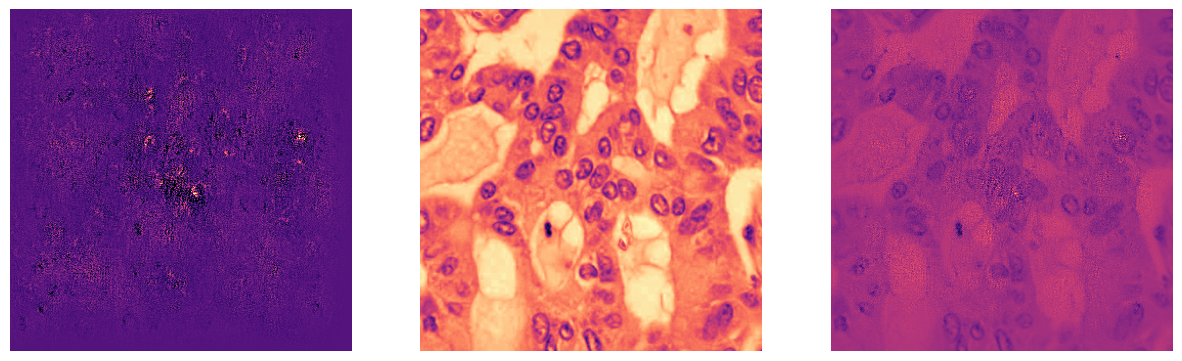

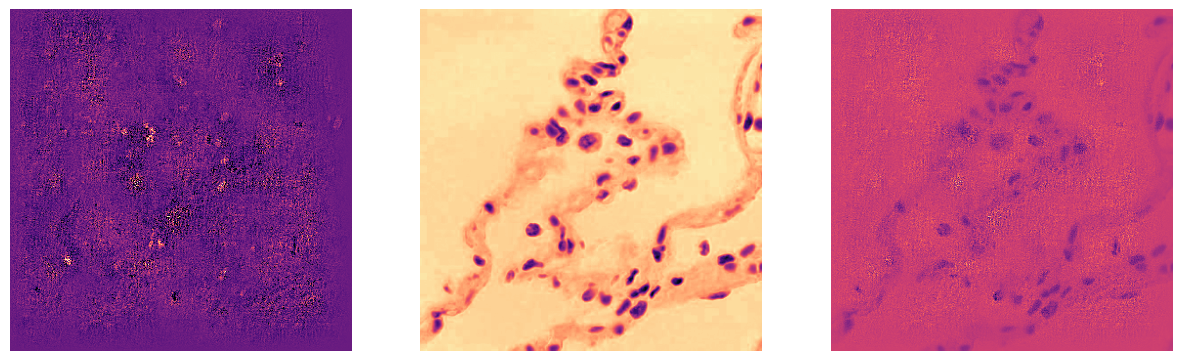

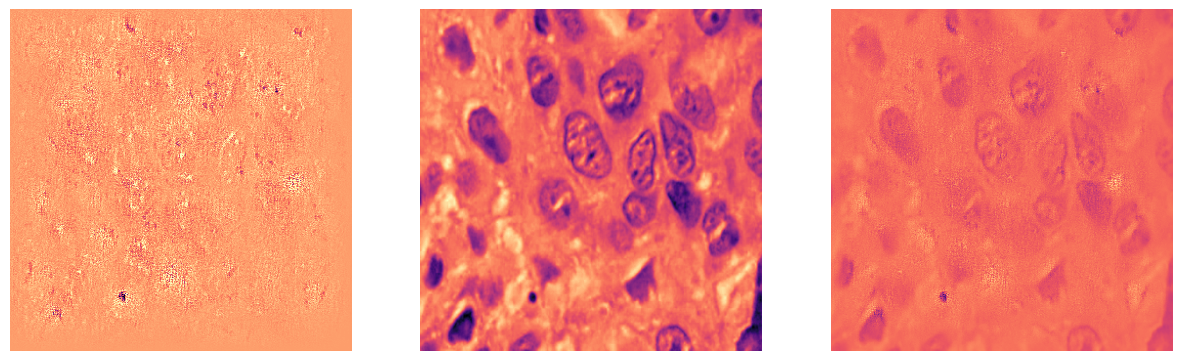

In [26]:
# Se generan los Saliency Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_saliency(selected_images[i], SimpleConv, preprocessing_simpleConv, saliency_paths[i])

#### Class Activation Map

In [68]:
#Se declaran variables necesarias para draw_CAM

img_size = (350, 350)
alpha = 1

In [69]:
# Se crea una lista con los paths en los que guardar los Class Activation Maps de esta red neuronal para cada una de las imágenes seleccionadas.
cam_paths = ['./CamMaps/aca_SimpleConv.jpg', './CamMaps/n_SimpleConv.jpg', './CamMaps/scc_SimpleConv.jpg']

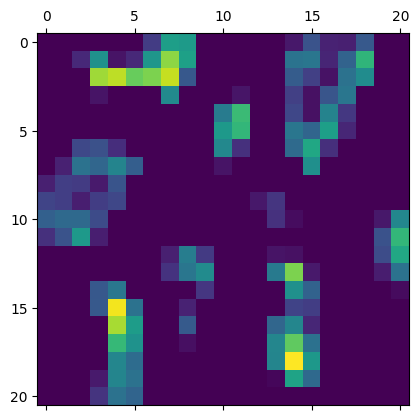

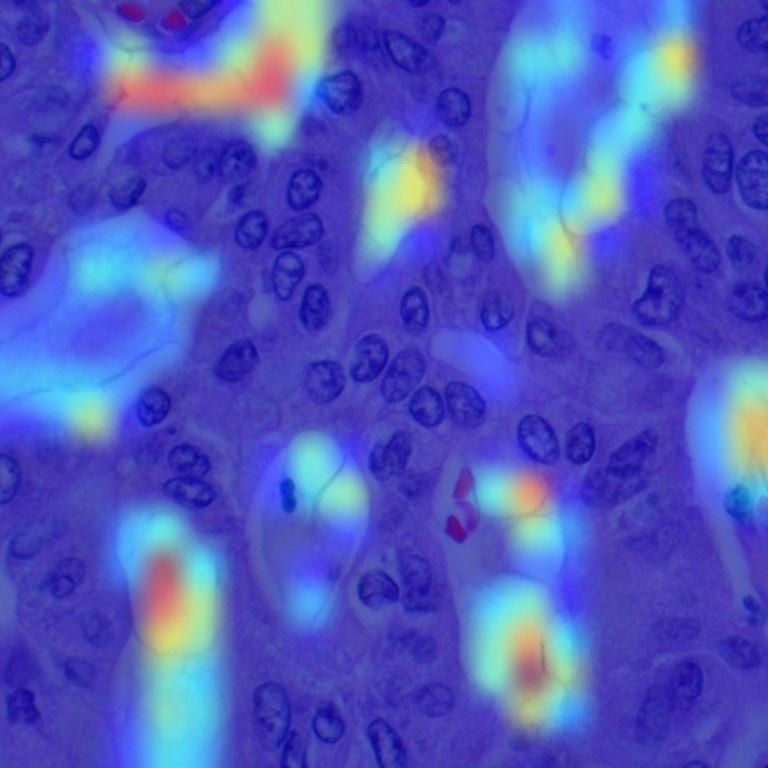

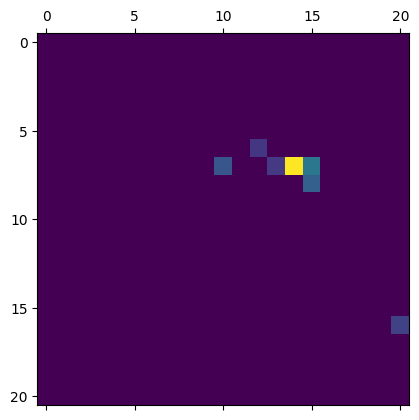

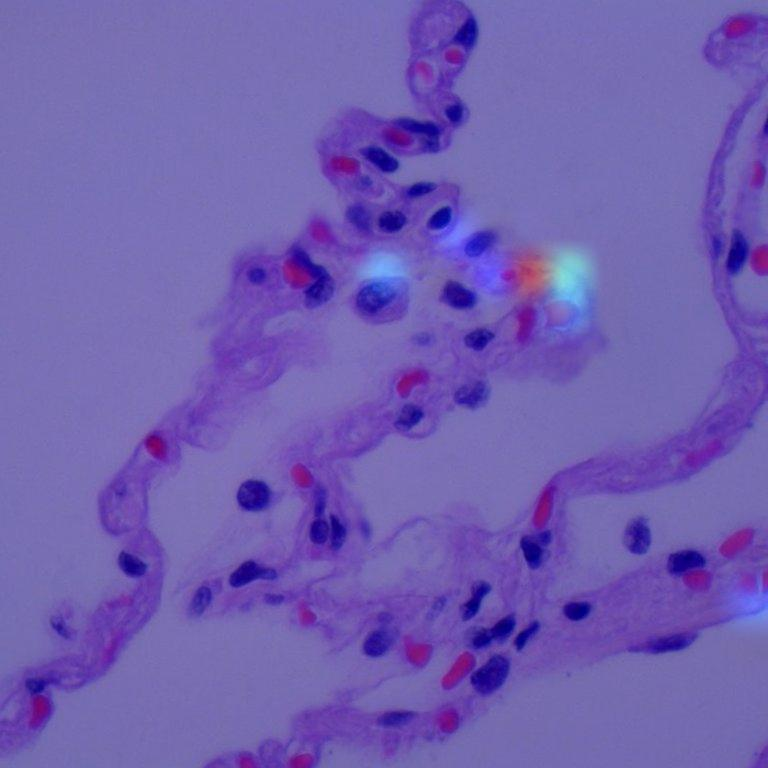

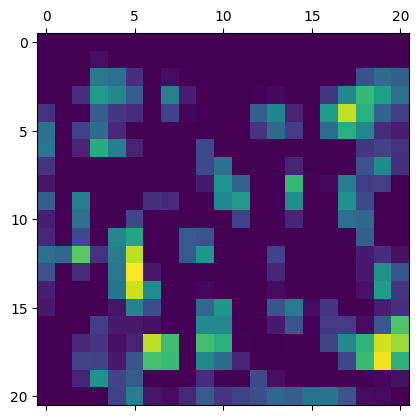

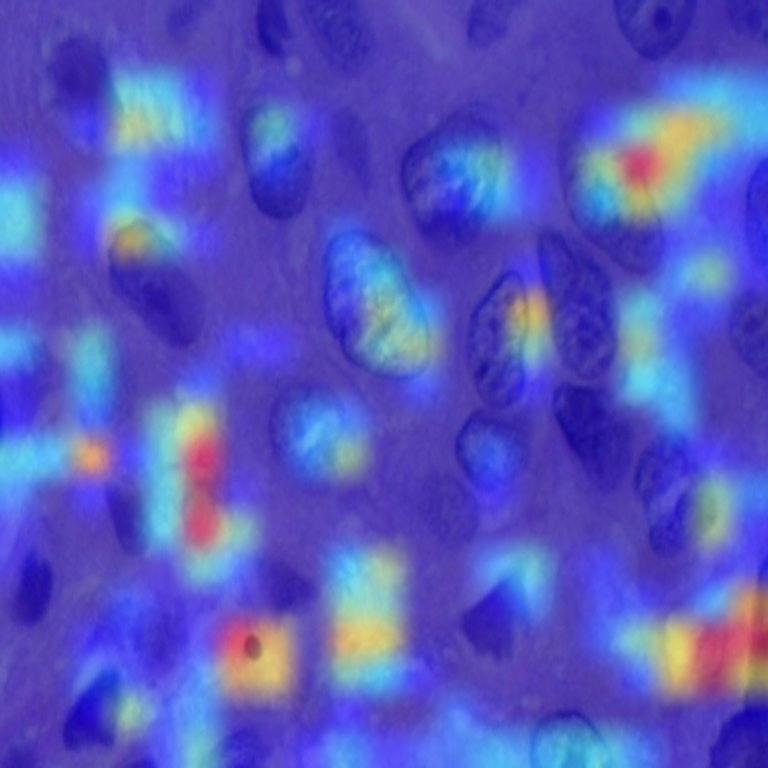

In [70]:
# Se generan los Class Activation Maps, se muestran por pantalla y se guardan en los paths correspondientes.
for i in range(len(selected_images)):
    draw_CAM(selected_images[i], img_size, SimpleConv, 'simpleConv', cam_paths[i], alpha, preprocessing_simpleConv, pred_index = None)